In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate
from tensorflow.keras.models import Model
import tensorflow.data
from tensorflow.keras.regularizers import L2
from joblib import load
import pydot

In [2]:
df=pd.read_pickle("intermediate_data/merged_final.pkl")

In [3]:
df

,user_id,anime_id,rating,Mean Score,age,Female,Male,Non-Binary,Unknown_Gender,Score,...,Vampire,Yaoi,Yuri,studio_col_1,studio_col_2,studio_col_3,studio_col_4,studio_col_5,studio_col_6,studio_col_7
0,1,37403,8,-0.696093,39.000000,0,1,0,0,7.35,...,0,0,0,110,0,0,0,0,0,0
1,44,37403,0,-0.477731,33.691944,0,1,0,0,7.35,...,0,0,0,110,0,0,0,0,0,0
2,82,37403,0,-0.887547,35.000000,0,1,0,0,7.35,...,0,0,0,110,0,0,0,0,0,0
3,111,37403,8,-0.887547,33.691944,0,0,0,1,7.35,...,0,0,0,110,0,0,0,0,0,0
4,222,37403,9,0.304332,37.000000,0,1,0,0,7.35,...,0,0,0,110,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59968475,100869,48492,0,-0.383379,34.000000,1,0,0,0,6.51,...,0,0,0,0,0,0,0,0,0,0
59968476,239658,48492,0,-0.102392,33.000000,1,0,0,0,6.51,...,0,0,0,0,0,0,0,0,0,0
59968477,310503,48492,0,1.699864,33.691944,0,0,0,1,6.51,...,0,0,0,0,0,0,0,0,0,0
59968478,123205,48481,0,0.267613,33.000000,1,0,0,0,6.51,...,0,0,0,46,0,0,0,0,0,0


In [3]:
df.columns

Index(['user_id', 'anime_id', 'rating', 'Mean Score', 'age', 'Female', 'Male',
       'Non-Binary', 'Unknown_Gender', 'Score', 'Movie', 'Music_Type', 'ONA',
       'OVA', 'Special', 'TV', 'Unknown_Type', '4-koma manga', 'Book',
       'Card game', 'Digital manga', 'Game_Source', 'Light novel', 'Manga',
       'Music_Source', 'Novel', 'Original', 'Other', 'Picture book', 'Radio',
       'Unknown_Source', 'Visual novel', 'Web manga', 'Action', 'Adventure',
       'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy',
       'Game', 'Harem', 'Hentai', 'Historical', 'Horror', 'Josei', 'Kids',
       'Magic', 'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery',
       'Parody', 'Police', 'Psychological', 'Romance', 'Samurai', 'School',
       'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai',
       'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural',
       'Thriller', 'Unknown_Genre', 'Vampire', 'Yaoi', 'Yuri', 'studio_col_1',
       'studi

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59968480 entries, 0 to 59968479
Data columns (total 84 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         int32  
 1   anime_id        int32  
 2   rating          int8   
 3   Mean Score      float32
 4   age             float32
 5   Female          int8   
 6   Male            int8   
 7   Non-Binary      int8   
 8   Unknown_Gender  int8   
 9   Score           float32
 10  Movie           int8   
 11  Music_Type      int8   
 12  ONA             int8   
 13  OVA             int8   
 14  Special         int8   
 15  TV              int8   
 16  Unknown_Type    int8   
 17  4-koma manga    int8   
 18  Book            int8   
 19  Card game       int8   
 20  Digital manga   int8   
 21  Game_Source     int8   
 22  Light novel     int8   
 23  Manga           int8   
 24  Music_Source    int8   
 25  Novel           int8   
 26  Original        int8   
 27  Other           int8   
 28  Picture bo

In [5]:
len(df.columns)

84

In [6]:
studio_to_int=load('intermediate_data/studio_to_int_vocab_dict.pkl')
num_studios=len(studio_to_int)
num_studios

689

In [7]:
user_input_shape=6

In [8]:
anime_input_shape=68

In [9]:
studio_max_length = 7

In [10]:
user_columns=df.columns[3:9]
anime_columns=df.columns[9:-7]
anime_embedding_columns=df.columns[-7:]

In [7]:
def user_data_generator(df, batch_size=32):
    while True:
        for i in range(0, len(df), batch_size):
            batch_df = df.iloc[i:i+batch_size]
            features = {col: np.array(batch_df[col]) for col in user_columns}
            yield features

def anime_data_generator(df, batch_size=32):
    while True:
        for i in range(0, len(df), batch_size):
            batch_df = df.iloc[i:i+batch_size]
            features = {col: np.array(batch_df[col]) for col in anime_columns}
            yield features

def anime_embedding_data_generator(df, batch_size=32):
    while True:
        for i in range(0, len(df), batch_size):
            batch_df = df.iloc[i:i+batch_size]
            features = {col: np.array(batch_df[col]) for col in anime_embedding_columns}
            yield features

def rating_data_generator(df, batch_size=32):
    while True:
        for i in range(0, len(df), batch_size):
            batch_df = df.iloc[i:i+batch_size]
            target = np.array(batch_df['rating'])
            yield target


In [9]:

# Create TensorFlow datasets using the generators
batch_size = 2048

user_metadata_dataset = tf.data.Dataset.from_generator(
    lambda: user_data_generator(df, batch_size),
    output_signature={col: tf.TensorSpec(shape=(None,), dtype=tf.float32) for col in user_columns}
)

anime_metadata_dataset = tf.data.Dataset.from_generator(
    lambda: anime_data_generator(df, batch_size),
    output_signature={col: tf.TensorSpec(shape=(None,), dtype=tf.float32) for col in anime_columns}
)

anime_embedding_dataset = tf.data.Dataset.from_generator(
    lambda: anime_embedding_data_generator(df, batch_size),
    output_signature={col: tf.TensorSpec(shape=(None,), dtype=tf.float32) for col in anime_embedding_columns}
)

ratings_dataset = tf.data.Dataset.from_generator(
    lambda: rating_data_generator(df, batch_size),
    output_signature=tf.TensorSpec(shape=(None,), dtype=tf.float32)
)

In [11]:
def user_metadata_generator():
    for row in df[user_columns].itertuples(index=False):
        yield row

def anime_metadata_generator():
    for row in df[anime_columns].itertuples(index=False):
        yield row

def anime_embedding_generator():
    for row in df[anime_embedding_columns].itertuples(index=False):
        yield row

def ratings_generator():
    for rating in df['rating'].values:
        yield rating

In [12]:
user_metadata_dataset = tf.data.Dataset.from_generator(user_metadata_generator, output_types=tf.float32, output_shapes=(len(user_columns)))
anime_metadata_dataset = tf.data.Dataset.from_generator(anime_metadata_generator, output_types=tf.float32, output_shapes=(len(anime_columns)))
anime_embedding_dataset = tf.data.Dataset.from_generator(anime_embedding_generator, output_types=tf.float32, output_shapes=(len(anime_embedding_columns)))
ratings_dataset = tf.data.Dataset.from_generator(ratings_generator, output_types=tf.float32)

In [13]:
dataset = tf.data.Dataset.zip(({'user_input':user_metadata_dataset, 'anime_input':anime_metadata_dataset,'anime_embedding_input':anime_embedding_dataset}, ratings_dataset))


In [10]:
dataset.save('data/dataset')

In [4]:
# Take one element from the dataset
sample_row = next(iter(dataset.take(1)))

# Print the sample row
print("Sample Row:", sample_row)

Sample Row: ({'anime_embedding_input': {'studio_col_6': <tf.Tensor: shape=(2048,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>, 'studio_col_5': <tf.Tensor: shape=(2048,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>, 'studio_col_2': <tf.Tensor: shape=(2048,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>, 'studio_col_7': <tf.Tensor: shape=(2048,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>, 'studio_col_4': <tf.Tensor: shape=(2048,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>, 'studio_col_1': <tf.Tensor: shape=(2048,), dtype=float32, numpy=array([110., 110., 110., ..., 110., 110., 110.], dtype=float32)>, 'studio_col_3': <tf.Tensor: shape=(2048,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>}, 'user_input': {'Male': <tf.Tensor: shape=(2048,), dtype=float32, numpy=array([1., 1., 1., ..., 1., 0., 0.], dtype=float32

In [2]:
dataset=tf.data.Dataset.load("data/dataset")

In [14]:
size = dataset.cardinality().numpy()

In [15]:
size = 59968480

In [16]:
dataset=dataset.shuffle(int(size))
train_size = int(0.8 * size)  # Assuming an 80-10-10 split
val_size =int(0.1*size)
train_dataset = dataset.take(train_size)    
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size).skip(val_size)


In [17]:
batch_size = 32
train_dataset=train_dataset.shuffle(batch_size*10)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
def user_model(input_shape):
    input=Input(shape=(input_shape,))
    x=Dense(64,activation='relu', kernel_regularizer=L2())(input)
    x=Dense(32,activation='relu',kernel_regularizer=L2())(x)
    output=Dense(16,activation='relu',kernel_regularizer=L2())(x)
    model = tf.keras.Model(inputs=input, outputs=output)
    return model
    
    
    


In [19]:
def anime_model(input_shape):
    input = Input(shape=(input_shape,),name='anime_inputs')
    input_studio= Input(shape=(studio_max_length,),name='anime_embeddings_inputs')
    studio_embedding=tf.keras.layers.Embedding(input_dim=num_studios+1,output_dim=4)(input_studio)
    studio_flattened = tf.keras.layers.Flatten()(studio_embedding)
    x=Concatenate()([input,studio_flattened])
    x=Dense(64,activation='relu', kernel_regularizer=L2())(x)
    x=Dense(32,activation='relu',kernel_regularizer=L2())(x)
    output=Dense(16,activation='relu',kernel_regularizer=L2())(x)
    model=Model(inputs=[input,input_studio],outputs=output)
    return model


In [20]:
def merge_models(model_1, model_2, user_input_shape , anime_input_shape):
    user_inputs = tf.keras.Input(shape=(user_input_shape,),name='user_input')
    anime_inputs=tf.keras.Input(shape=(anime_input_shape,),name='anime_input')
    anime_embeddings_inputs=tf.keras.Input(shape=(studio_max_length),name='anime_embedding_input')
    output_1 = model_1(user_inputs)
    output_2 = model_2([anime_inputs,anime_embeddings_inputs])
    merged = Concatenate()([output_1, output_2])
    outputs = Dense(1,activation='relu',kernel_regularizer=L2())(merged)
    model = tf.keras.Model(inputs=[user_inputs,anime_inputs,anime_embeddings_inputs], outputs=outputs)
    return model

In [21]:
model1=user_model(user_input_shape)
model2=anime_model(anime_input_shape)
model3=merge_models(model1,model2,user_input_shape,anime_input_shape)

In [22]:
model3.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [23]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense (Dense)               (None, 64)                448       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
Total params: 3,056
Trainable params: 3,056
Non-trainable params: 0
_________________________________________________________________


In [24]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anime_embeddings_inputs (Input  [(None, 7)]         0           []                               
 Layer)                                                                                           
                                                                                                  
 embedding (Embedding)          (None, 7, 4)         2760        ['anime_embeddings_inputs[0][0]']
                                                                                                  
 anime_inputs (InputLayer)      [(None, 68)]         0           []                               
                                                                                                  
 flatten (Flatten)              (None, 28)           0           ['embedding[0][0]']        

In [25]:
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 6)]          0           []                               
                                                                                                  
 anime_input (InputLayer)       [(None, 68)]         0           []                               
                                                                                                  
 anime_embedding_input (InputLa  [(None, 7)]         0           []                               
 yer)                                                                                             
                                                                                                  
 model (Functional)             (None, 16)           3056        ['user_input[0][0]']       

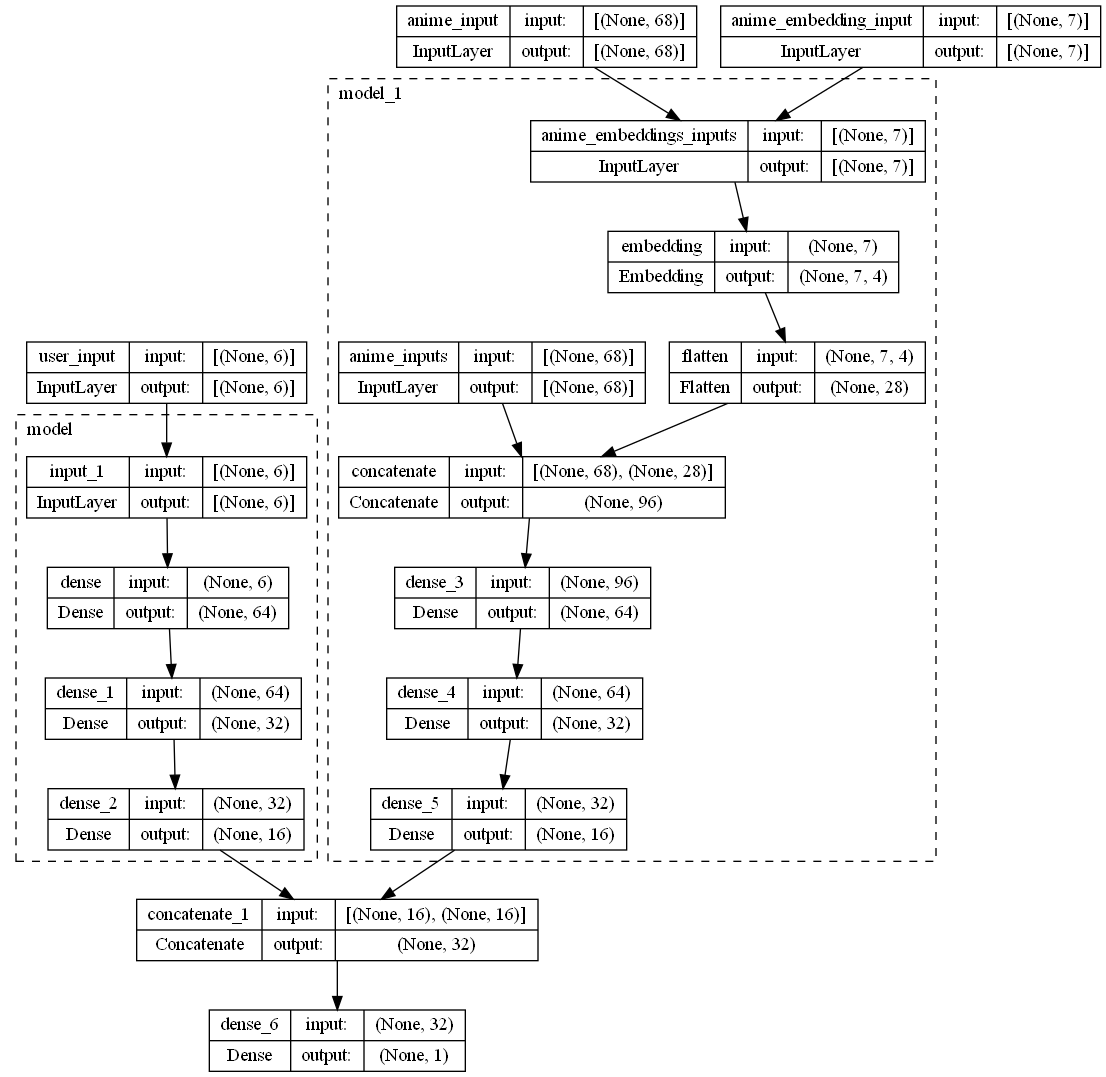

In [26]:
import pydot
import pydotplus
import graphviz
tf.keras.utils.plot_model(
model3,
to_file="model.png",
show_shapes=True,
show_layer_names=True,
rankdir="TB",
expand_nested=True,
dpi=96,
)


In [27]:
num_epochs = 2000
batch_size = 1100


model3.fit(train_dataset, epochs=10)

Epoch 1/10


In [2]:
df=pd.read_pickle("merged_final.pkl")